In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import warnings
warnings.filterwarnings(action='ignore')
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.5"

In [ ]:
# os.environ['XLA_FLAGS'] = ''
os.environ['XLA_FLAGS'] = '--xla_gpu_force_compilation_parallelism=1'
import random

In [ ]:
from energy_transformer.tools import save, load
from celluloid import Camera
from tqdm import tqdm

from fastcore.basics import patch
from matplotlib.animation import ArtistAnimation
import matplotlib.pyplot as plt

import jax
import flax

from dataclasses import dataclass
from energy_transformer.flax_training_unified import Trainer, TrainConfig, _img_results_for_logging, show_predictions, gridify_img_results, imagenet_unnormalize_image
from energy_transformer.torch_dataloader.imagenet import normalizer
from flax.training import checkpoints
from torchvision import transforms as tfms

import functools as ft
import jax.numpy as jnp
import numpy as np
from einops import rearrange

from pathlib import Path

2022-10-28 10:36:09.159144: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 10:36:09.634534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-28 10:36:09.634602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-28 10:36:09.634608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# Load the model

In [ ]:
@dataclass
class Config:
    pretrained_model: str # Path to pretrained model to evaluate
    batch_size: int = 10 # Number of images to evaluate
    img_idx:int = 0
    depth: int = 12
    alpha: float = 0.02
    color_jitter=0.

ckpt = Path("../saved_checkpoints/checkpoint_-0.2996683120727539") # Behaves like the other pos embeds

conf = Config(ckpt)

train_config = TrainConfig("/raid/ILSVRC2012/train/", "/raid/ILSVRC2012/val-by-class/", batch_size=conf.batch_size, depth=conf.depth, alpha=conf.alpha) # Base model has no modifications
trainer = Trainer(train_config)

train_dl, val_dl = trainer.make_dataloaders()
for batch in train_dl():
    break
img, mask, c = batch
mask[mask == 2] = 1
    
nmask = (mask == 1).sum(-1)[0] # We only want mask == 1
model = trainer.make_model(nmask)

lr_fn, opt = trainer.make_optimizer(steps_per_epoch=len(train_dl))
state = trainer.create_train_state(jax.random.PRNGKey(0), model, opt)
state = checkpoints.restore_checkpoint(ckpt.parent, state)

MULTISCATTERING
Patcher:  196 14 14


In [ ]:
iterthrough = jax.vmap(ft.partial(model.apply, method=model.collect_energies), in_axes=(None, 0,0), out_axes=(0,(0,0)))
output = iterthrough({"params": state.params}, img, mask)
# model.apply({"params": state.params}, img, mask)

final_img, (energies, embeddings) = output
energies = jnp.stack(energies)
embeddings = jnp.stack(embeddings)[:,:,1:]
decode = jax.jit(jax.vmap(ft.partial(model.apply, method=model.decode), in_axes=(None, 0), out_axes=(0)))
seqdecode = jax.vmap(decode, in_axes=(None, 0), out_axes=(0))
reconstructions = seqdecode({"params": state.params}, embeddings)

# Visualize patch embeddings

In [ ]:
import matplotlib.pyplot as plt
from einops import rearrange
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import cm

# Visualize the memories

In [ ]:
state.params['backbone']['encoder']['kernel'].shape

(768, 768)

In [ ]:
state.params.keys()

frozen_dict_keys(['backbone', 'decoder'])

In [ ]:
params = {"params": state.params}
block_params = params['params']['backbone']['block']
Wk = block_params['attn']['Wk']
Wq = block_params['attn']['Wq']
# Wv = jnp.einsum("hzd,hzd->hzd", Wq, Wk) # WRONG
Wv = jnp.einsum("hzi,hzj->hij", Wq, Wk) # Query, key
XX = block_params['chn']['kernel']
ENC_W =state.params['backbone']['encoder']['kernel']
DEC_W =state.params['decoder']['kernel']

H, Z, D = Wk.shape
_, Mu = XX.shape

In [ ]:
im_mean = np.array([0.485, 0.456, 0.406])
im_std = np.array([0.229, 0.224, 0.225])

@ft.partial(interact, head=widgets.IntSlider(min=0, max=H-1, step=1, value=0),
            idx=widgets.IntSlider(min=0, max=Z-1, step=1, value=0))
def show_attn_mems(head:int, idx:int):
    memk = Wk[head][idx]
    memq = Wq[head][idx]
    memv = Wv[head][idx]

    dmemk = model.apply(params, memk, method=model.decode)
    dmemq = model.apply(params, memq, method=model.decode)
    dmemv = model.apply(params, memv, method=model.decode)

    
    dmemk_show = np.clip((rearrange(dmemk, "c h w -> h w c") * im_std) + im_mean, 0, 1)
    dmemq_show = np.clip((rearrange(dmemq, "c h w -> h w c") * im_std) + im_mean, 0, 1)
    dmemv_show = np.clip((rearrange(dmemv, "c h w -> h w c") * im_std) + im_mean, 0, 1)


    print(dmemk_show.min())
    fig, axs = plt.subplots(1,3, figsize=(18,6))
    axs[0].imshow(dmemk_show)
    axs[0].set_title("Wk")

    axs[1].imshow(dmemq_show)
    axs[1].set_title("Wq")

    axs[2].imshow(dmemv_show)
    axs[2].set_title("Wv")
    
    plt.suptitle(f"Decoded memories for (head={head},  memory={idx})")

interactive(children=(IntSlider(value=0, description='head', max=11), IntSlider(value=0, description='idx', ma…

In [ ]:
im_mean = np.array([0.485, 0.456, 0.406])
im_std = np.array([0.229, 0.224, 0.225])

def show_value_attn_mems():
    
    H,Z,D = Wk.shape
    # klist = []
    # qlist = []
    vklist = []
    vqlist = []
    
    for head in range(H):
        # memk = Wk[head] # Z,D
        # memq = Wq[head] # Z,D
        memvq = Wv[head] # Q,D
        memvk = Wv[head] # K,D


        mapply = ft.partial(model.apply, method=model.decode)
        decode_mem = jax.vmap(mapply, in_axes=(None,0), out_axes=(0))
        # dmems = decode_mem(params, XX.T)

        # dmemk = decode_mem(params, memk) # Z,C,H,W
        # dmemq = decode_mem(params, memq)
        dmemvk = decode_mem(params, memvk) # Kchw
        dmemvq = decode_mem(params, memvq) # Qchw

        nh = nw = int(np.sqrt(D))
        N = nh * nw
        dmemvk_show = np.clip((rearrange(dmemvk[:N], "(nh nw) c h w -> (nh h) (nw w) c", nh=nh, nw=nw) * im_std) + im_mean, 0, 1)
        dmemvq_show = np.clip((rearrange(dmemvq[:N], "(nh nw) c h w -> (nh h) (nw w) c", nh=nh, nw=nw) * im_std) + im_mean, 0, 1)
        
        vklist.append(np.pad(dmemvk_show, ((1,1),(1,1),(0,0))))
        vqlist.append(np.pad(dmemvq_show, ((1,1),(1,1),(0,0))))
    
    nw = int(np.sqrt(H))
    nh = H // nw
    N = nh * nw
    dmemvks_show = rearrange(vklist[:N], "(nh nw) h w c -> (nh h) (nw w) c", nh=nh, nw=nw)
    dmemvqs_show = rearrange(vqlist[:N], "(nh nw) h w c -> (nh h) (nw w) c", nh=nh, nw=nw)
    # dmemvs_show = rearrange(vlist[:N], "(nh nw) h w c -> (nh h) (nw w) c", nh=nh, nw=nw)

    print(dmemks_show.shape)

    fig, axs = plt.subplots(1,2, figsize=(8,4), dpi=300)
    axs[0].imshow(dmemvks_show)
    axs[0].set_title("Wvk")
    axs[0].axis('off')

    axs[1].imshow(dmemvqs_show)
    axs[1].set_title("Wvq")
    axs[1].axis('off')

    # axs[2].imshow(dmemvs_show)
    # axs[2].set_title("Wv")
    # axs[2].axis('off')

    
    fig.savefig("./figures/value_head_mems.png")


In [ ]:
# show_value_attn_mems()

In [ ]:
def show_kq_attn_mems():
    
    H,Z,D = Wk.shape
    klist = []
    qlist = []
    vlist = []
    
    for head in range(H):
        memk = Wk[head] # Z,D
        memq = Wq[head]
        # memv = Wv[head]

        mapply = ft.partial(model.apply, method=model.decode)
        decode_mem = jax.vmap(mapply, in_axes=(None,0), out_axes=(0))
        dmems = decode_mem(params, XX.T)

        dmemk = decode_mem(params, memk) # Z,C,H,W
        dmemq = decode_mem(params, memq)
        # dmemv = decode_mem(params, memv)

        nh = nw = int(np.sqrt(Z))
        N = nh * nw

        dmemk_show = np.clip((rearrange(dmemk[:N], "(nh nw) c h w -> (nh h) (nw w) c", nh=nh, nw=nw) * im_std) + im_mean, 0, 1)
        dmemq_show = np.clip((rearrange(dmemq[:N], "(nh nw) c h w -> (nh h) (nw w) c", nh=nh, nw=nw) * im_std) + im_mean, 0, 1)
        # dmemv_show = np.clip((rearrange(dmemv[:N], "(nh nw) c h w -> (nh h) (nw w) c", nh=nh, nw=nw) * im_std) + im_mean, 0, 1)

        klist.append(np.pad(dmemk_show, ((1,1),(1,1),(0,0))))
        qlist.append(np.pad(dmemq_show, ((1,1),(1,1),(0,0))))
        # vlist.append(np.pad(dmemv_show, ((1,1),(1,1),(0,0))))
    
    nw = int(np.sqrt(H))
    nh = H // nw
    N = nh * nw
    dmemks_show = rearrange(klist[:N], "(nh nw) h w c -> (nh h) (nw w) c", nh=nh, nw=nw)
    dmemqs_show = rearrange(qlist[:N], "(nh nw) h w c -> (nh h) (nw w) c", nh=nh, nw=nw)
    # dmemvs_show = rearrange(vlist[:N], "(nh nw) h w c -> (nh h) (nw w) c", nh=nh, nw=nw)

    print(dmemks_show.shape)

    fig, axs = plt.subplots(1,2, figsize=(4,3), dpi=300)
    axs[0].imshow(dmemks_show)
    axs[0].set_title("Wk")
    axs[0].axis('off')

    axs[1].imshow(dmemqs_show)
    axs[1].set_title("Wq")
    axs[1].axis('off')

    # axs[2].imshow(dmemvs_show)
    # axs[2].set_title("Wv")
    # axs[2].axis('off')

    
    fig.savefig("./figures/kq_head_mems.png")


(520, 390, 3)


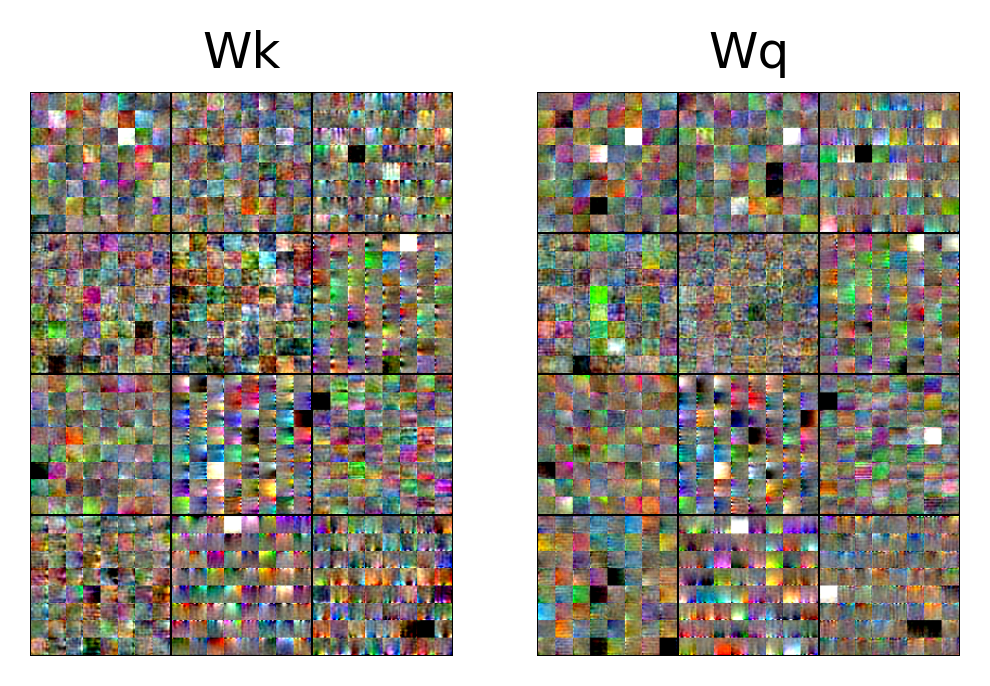

In [ ]:
show_kq_attn_mems()

In [ ]:
def show_all_chn_mems(nmems=None, force_idxs=[], seed=42, spacing=0):
    np.random.seed(seed)
    mapply = ft.partial(model.apply, method=model.decode)
    decode_mem = jax.vmap(mapply, in_axes=(None,0), out_axes=(0))
    dmems = decode_mem(params, XX.T)
    force_idxs = np.array(force_idxs)
    choice_idxs =  np.array([x for x in np.arange(dmems.shape[0]) if x not in set(force_idxs)])
    if nmems is None:
        nmems = dmems.shape[0]
        nw = nh = int(np.sqrt(nmems))
        idxs = np.arange(dmems.shape[0])[:nw*nh]
    else:
        idxs = np.arange(dmems.shape[0])
        nw = nh = int(np.sqrt(nmems))
        idxs = np.random.choice(choice_idxs, nw*nh, replace=False)
        
    print(nw, nh, nw*nh)
    insert_idxs = np.arange(nw*nh)
    np.random.shuffle(insert_idxs)
    idxs[insert_idxs[:len(force_idxs)]] = force_idxs
    dmem_chosen = dmems[idxs]
    dmem_chosen = np.pad(np.stack(dmem_chosen), ((0,0), (0,0), (spacing,spacing), (spacing,spacing)), constant_values=100.)
    dmem_show = np.clip((rearrange(dmem_chosen, "(nh nw) c h w -> (nh h) (nw w) c", nh=nh, nw=nw) * im_std) + im_mean, 0, 1)

    # dmem_show = np.clip((rearrange(dmems[:(nh*nw)], "(nh nw) c h w -> (nh h) (nw w) c", nh=nh, nw=nw) * im_std) + im_mean, 0, 1)

    fig, ax = plt.subplots(1, figsize=(6,6), dpi=300)
    ax.axis('off')
    ax.imshow(dmem_show)
    # ax.set_title("Memories of the Classical Hopfield Network")
    fig.savefig(f"./figures/chn_mems_{nmems}.png")
    return dmems

7 7 49


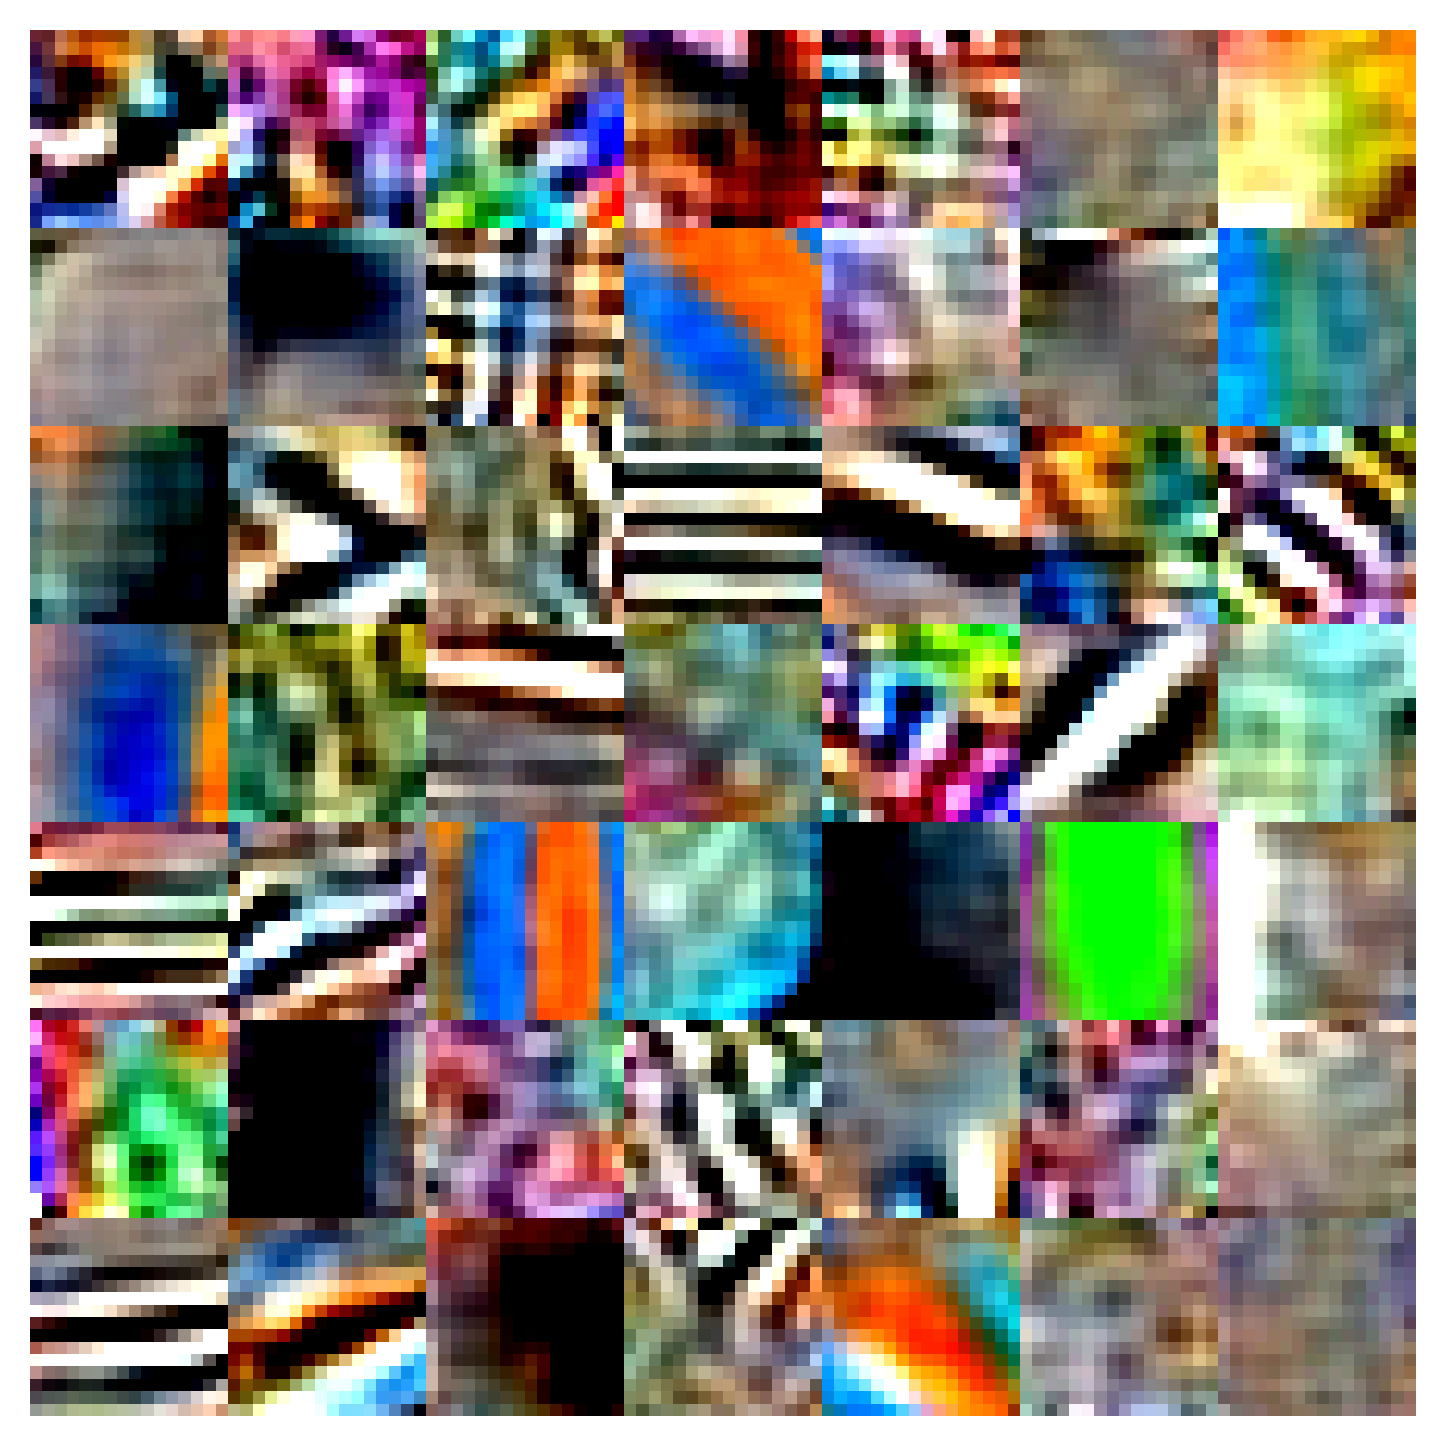

In [ ]:
# seed = 2
# dmems = show_all_chn_mems(36, [7,10,15,28,31,43,44,58,64,68,72,123,124,134,146,169,216], seed)

# seed = 3
# seed = 11
# seed = 44
seed = 62
# seed = 66
dmems = show_all_chn_mems(49, [7,10,15,28,31,43,44,58,64,68,72,123,124,134,146,169,216], seed)

55 55 3025


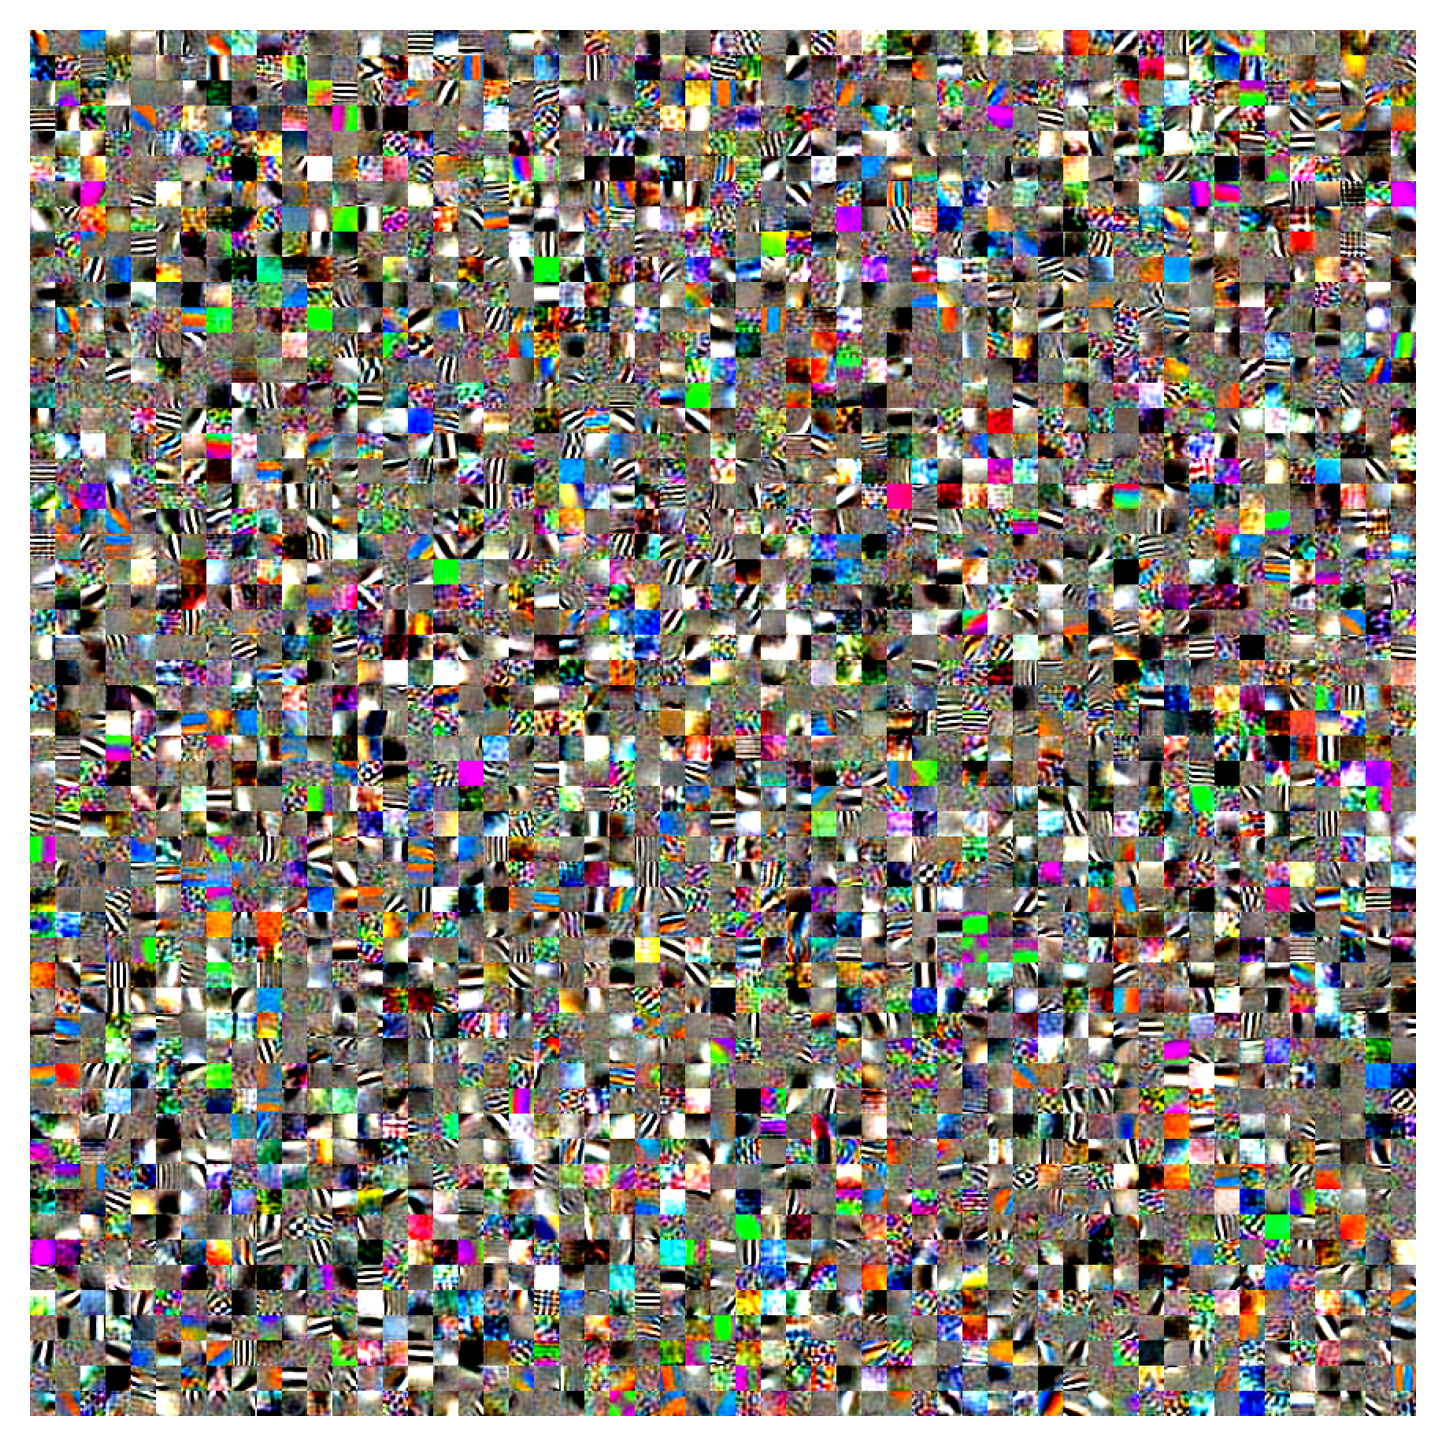

In [ ]:
dmems = show_all_chn_mems()

In [ ]:
interesting_idxs = [
    [0,5,7,10,16,23,28,29,31,32,44,45,46,47,48,49,55],
    [0,1,3,7,9,10,13,14,16,17,26,27,28,30,35,36,45,48],
    [2,7,15,24,27,36,37,38,39,40,43,44,45,46,47,48,50],
    [2,4,8,10,12,34,40,521,50,47],
    [6,7,8,14,15,20,22,23,39,30,32,41,42,48,49],
    [7,9,19,27,30,31],
    [8,18,19,22,23,24,30,34,52,50],
    [1,2,9,22,23,32,43,48,49],
    [1,4,27,30,42,52],
    [2,18,28,33,35,40,41,],
    [12,23,26,51],
    [1,6,7,10,14,15,18,19,20,21,24,30,32,43,45],
    [14,15,19,20,29],
    [13,20,23,29,32,44,48,53],
]
offset = [i*55 for i in range(14)]

idxs = [o + i for o,idx in zip(offset, interesting_idxs) for i in idx]

10 10 100


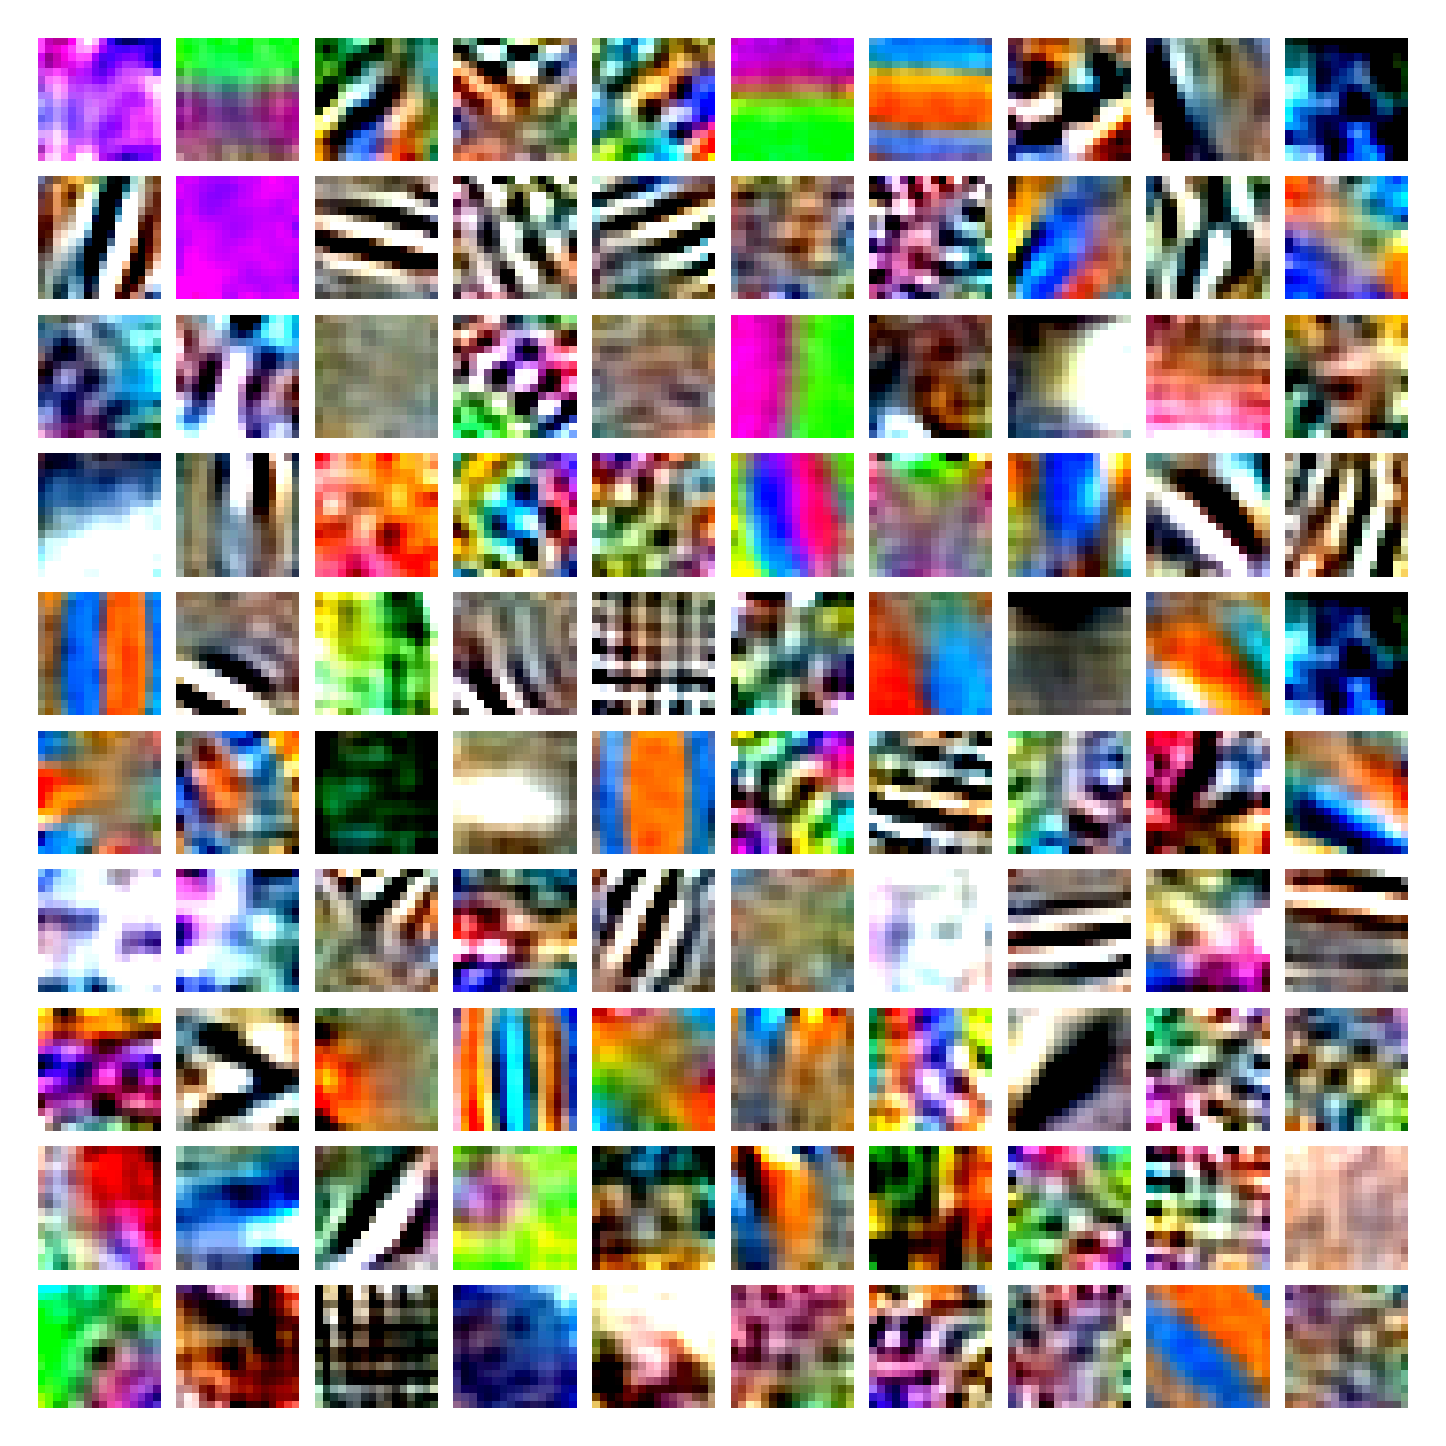

In [ ]:
import random
# seed = 2
seed = 5
idxs = np.random.choice(np.array(idxs), 100, replace=False)
dmems = show_all_chn_mems(100, idxs, seed=seed, spacing=1)


# Collect Image Reconstructions

In [ ]:
from energy_transformer.torch_dataloader.imagenet import TorchDataloaderAdapater, get_default_datamodule, MaskTypeTorch
from energy_transformer.flax_core import EnergyLayerNorm, MultiheadAttention, CHNReLU

In [ ]:
dm = get_default_datamodule("/raid/ILSVRC2012/train", "/raid/ILSVRC2012/val-by-class", patcher=model.backbone.patcher, batch_size=1000, masktype=trainer.config.mask_type, num_workers=1, auto_augment=None, color_jitter=0., hflip=0., scale=(1., 1.),shuffle_val=True)
dm.setup()
dm.seed(1)
train_dl = TorchDataloaderAdapater(dm.train_dataloader)
val_dl = TorchDataloaderAdapater(dm.val_dataloader)

MULTISCATTERING


In [ ]:
attn = MultiheadAttention(model.backbone.tokdim, model.backbone.nheads, model.backbone.kspace_dim)
attn_energy = ft.partial(attn.apply, {"params": params['params']['backbone']['block']['attn']}, method=attn.energy_and_grad)

chn = CHNReLU(model.backbone.tokdim, model.backbone.hidden_ratio)
chn_energy = ft.partial(chn.apply, {"params": params['params']['backbone']['block']['chn']}, method=chn.energy_and_grad)

mdecode = ft.partial(model.apply, method=model.decode)
decode_mem = jax.vmap(mdecode, in_axes=(None,0), out_axes=(0))

# All functions assume model and params are present in the global scope
encode = ft.partial(model.backbone.apply, {"params":params['params']['backbone']}, method=model.backbone.encode)
norm_layer = EnergyLayerNorm(model.backbone.tokdim)
norm = ft.partial(norm_layer.apply, {"params": params['params']['backbone']['norm']})

def iter_forward(img, mask, depth=12, alpha=0.1):
    x = encode(img)
    maskmask = jnp.nonzero(mask == 1, size=model.backbone.nmask, fill_value=0)
    x = x.at[maskmask].set(params['params']['backbone']['mask_token'])
    x = jnp.concatenate([params['params']['backbone']['cls_token'][None], x])
    x = x + params['params']['backbone']['pos_embed']
    
    representations = [x]
    dEdg_chns = []
    dEdg_attns = []

    @jax.jit
    def step(x):
        g = norm(x)
        
        E_attn, dEdg_attn = attn_energy(g)
        E_chn, dEdg_chn = chn_energy(g)
        
        next_x = x - alpha * (dEdg_attn + dEdg_chn)        
        return next_x, dEdg_chn, dEdg_attn
    
    for i in range(depth):
        x, dEdg_chn, dEdg_attn = step(x)
        representations.append(x)
        dEdg_chns.append(dEdg_chn)
        dEdg_attns.append(dEdg_attn)
        
    return representations, dEdg_chns, dEdg_attns

def show_patchified_img(x,mask=None):
    x = model.backbone.patcher.unpatchify(x)
    x = imagenet_unnormalize_image(x)
    return x

In [ ]:
for i, batch in enumerate(val_dl()):
    img, mask, c = batch
    if i == 1:
        break
mask[mask == 2] = 1

In [ ]:
imgs, masks, lbls = batch

In [ ]:
train_og = show_patchified_img(imgs)

In [ ]:
# Explore the images in the batch.
@ft.partial(interact, idx=widgets.IntSlider(min=0, max=train_og.shape[0]-1, step=1, value=0))
def show_batch_idx(idx:int=0):
    plt.imshow(train_og[idx])

# plt.imshow(train_og[idx])

interactive(children=(IntSlider(value=0, description='idx', max=999), Output()), _dom_classes=('widget-interac…

In [ ]:
valdl_batch0seed0_funidxs = [4,12,140,169,189]
valdl_batch1seed0_funidxs = [0,33,42,55,]
valdl_batch1_1000_seed0_funidxs = [56,59,73,86,98,139,332, 355,411,446,509,510,542,543,578,584,616,645,646,661] # !! Why this not working?
valdl_batch1_1000_seed0_funidxs_good_imgs = [0, 1, 2, 4, 7, 8,10,12,13,19]
valdl_batch1_1000_seed0_funidxs_good_imgs = [0, 1, 2, 4,10,12,13,19] #No tiger no compass

# I need 2 more imgs
valdl_batch1_1000_seed1_funidxs = [15,99,158,196,202,255,266,272]
valdl_batch1_1000_seed1_funidxs_good_imgs = [2,4]

fun_idxs = [z for i,z in enumerate(valdl_batch1_1000_seed0_funidxs) if i in valdl_batch1_1000_seed0_funidxs_good_imgs]
fun_idxs = [z for i,z in enumerate(valdl_batch1_1000_seed1_funidxs) if i in valdl_batch1_1000_seed1_funidxs_good_imgs]

In [ ]:
def show_img_reconstructions(data):
    # Where data is (x, mask)[]
    N = len(data)
    fig, axs = plt.subplots(1, N,figsize=(N,3), dpi=360, gridspec_kw=dict(
        left=0., bottom=0., right=1., top=1., wspace=0.05, hspace=0.1
    ))

    if isinstance(axs, np.ndarray):   
        for i in range(axs.shape[0]):
            axs[i].axes.xaxis.set_visible(False)
            axs[i].axes.yaxis.set_visible(False)
            axs[i].axis('off')
    
    for i, (x, mask) in enumerate(data):
        xpatched = x
        representations, dEdg_chns, dEdg_attns = iter_forward(xpatched, mask)
        
        show_recons = show_patchified_img(mdecode(params, representations[-1][1:]))
        show_xmasked = show_patchified_img(x * (1-mask[:,None,None,None]))
        show_xog = show_patchified_img(x)
        print(show_recons.shape, show_xmasked.shape, show_xog.shape)
        
        show_xmasked = np.pad(show_xmasked, ((1,1),(1,1),(0,0)), constant_values=0)
        show_recons = np.pad(show_recons, ((1,1),(1,1),(0,0)), constant_values=0)
        show_xog = np.pad(show_xog, ((1,1),(1,1),(0,0)), constant_values=0)

        showimg = rearrange([show_xmasked, show_recons, show_xog], "n h w c -> (n h) w c")
        if isinstance(axs, np.ndarray):   
            axs[i].imshow(showimg)
        else:
            axs.imshow(showimg)
    return fig

(224, 224, 3) (224, 224, 3) (224, 224, 3)
(224, 224, 3) (224, 224, 3) (224, 224, 3)


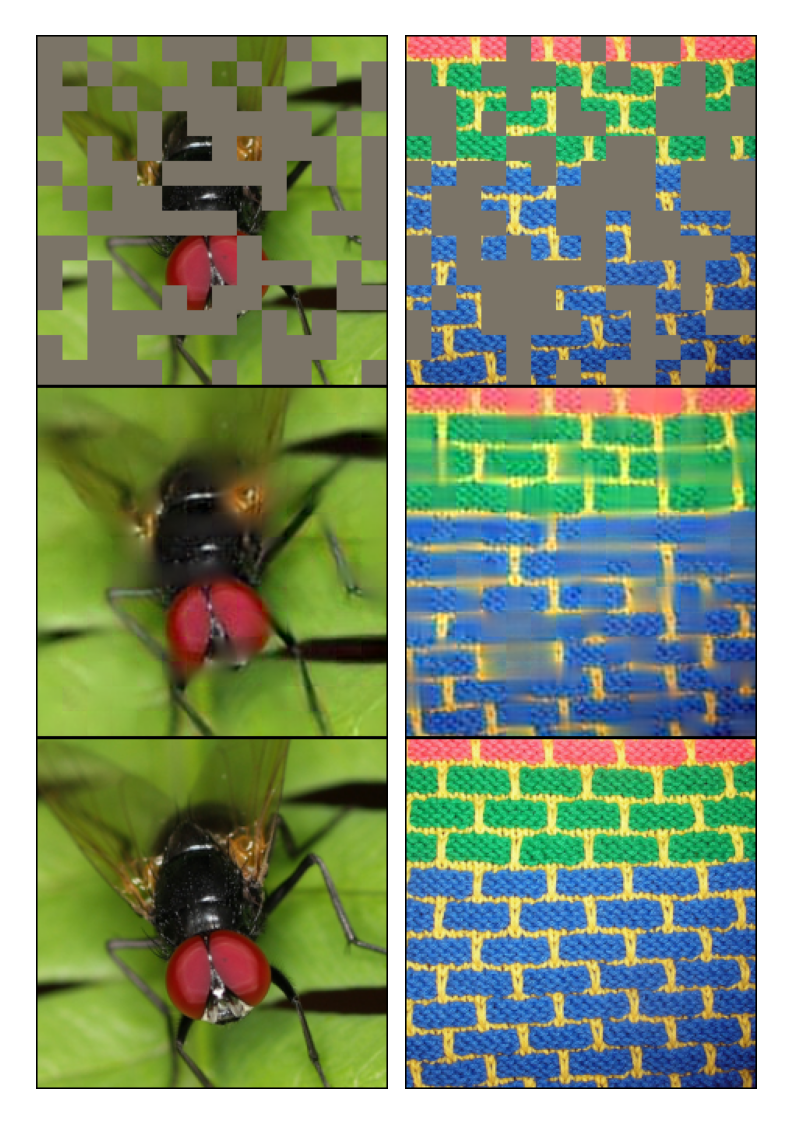

In [ ]:
dpoints = [(imgs[x], masks[x]) for x in fun_idxs]
fig = show_img_reconstructions(dpoints);